In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/AIO2024/london_energy.csv")
print(df.isna().sum())
df.head()

LCLid    0
Date     0
KWH      0
dtype: int64


LCLid        Date     KWH
0  MAC000002  2012-10-12   7.098
1  MAC000002  2012-10-13  11.087
2  MAC000002  2012-10-14  13.223
3  MAC000002  2012-10-15  10.257
4  MAC000002  2012-10-16   9.769

In [ ]:
df_avg_consumption = df.groupby("Date")["KWH"].mean()
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


<Axes: xlabel='date'>

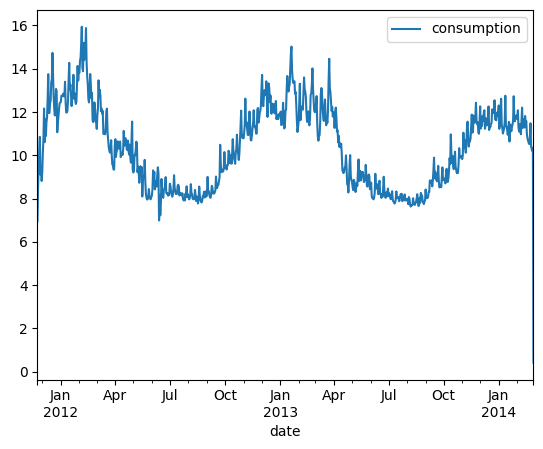

In [ ]:
df_avg_consumption.plot(x="date", y="consumption")


<Axes: xlabel='date'>

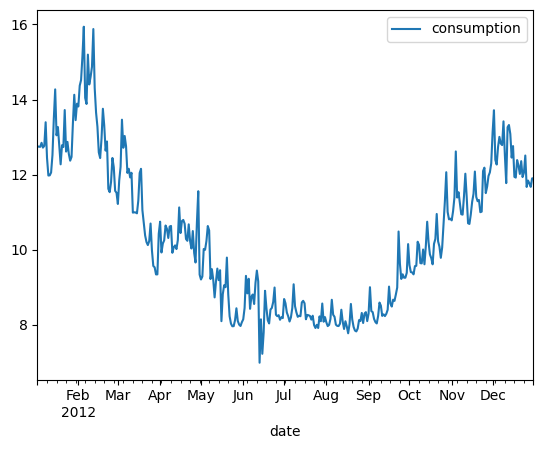

In [ ]:
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'").plot(x="date", y="consumption")


In [ ]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption.head()

date  consumption  day_of_week  day_of_year  month  quarter  year
0 2011-11-23     6.952692            2          327     11        4  2011
1 2011-11-24     8.536480            3          328     11        4  2011
2 2011-11-25     9.499781            4          329     11        4  2011
3 2011-11-26    10.267707            5          330     11        4  2011
4 2011-11-27    10.850805            6          331     11        4  2011

In [ ]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 7)
(216, 7)


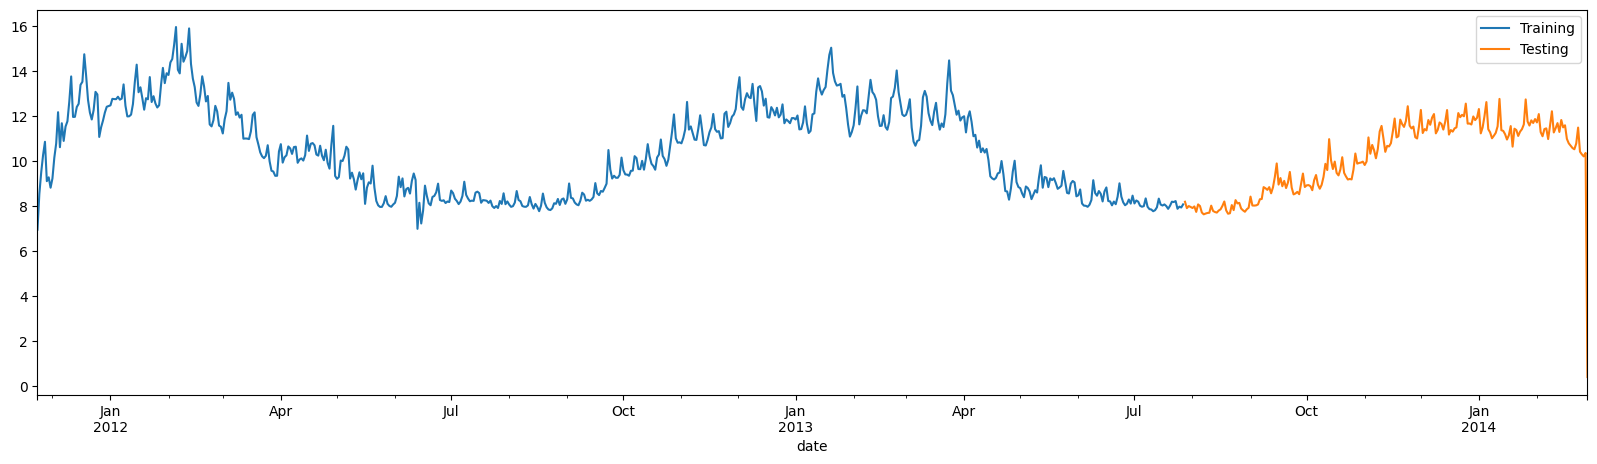

In [ ]:
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

In [ ]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["consumption"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["consumption"]

In [ ]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.3]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3],
                         'learning_rate': [0.01, 0.05], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 300]})

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

MAE: 0.7686541420987578
MSE: 1.499030547959475
MAPE: 0.19708401357186248


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = GradientBoostingRegressor()
parameters = {
    "max_features": [3, 4, 5],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [100, 300]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_features': [3, 4, 5],
                         'n_estimators': [100, 300]})

In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

MAE: 0.7535964848932999
MSE: 1.3449409757830804
MAPE: 0.1951895064391348


In [ ]:
print(prediction)

[ 8.615518    8.23605497  8.19103723  8.16748041  8.16748041  8.1708785
  8.24346692  8.615518    8.23605497  8.19103723  8.16748041  8.16748041
  8.1708785   8.24346692  8.615518    8.23605497  8.19103723  8.16748041
  8.16748041  8.1708785   8.24346692  8.615518    8.23605497  8.19103723
  8.16748041  8.16748041  8.1708785   8.24346692  8.615518    8.23605497
  8.19103723  8.16748041  8.16748041  8.1708785   8.24346692  8.66976281
  8.30379967  8.25878193  8.23522511  8.23522511  8.2386232   8.31121163
  8.66976281  8.30379967  8.25878193  8.29790133  8.29790133  8.30129941
  8.37388784  8.72173332  8.37815657  8.51047541  8.50506396  8.50506396
  8.57474805  8.71543828  9.27072432  8.87425145  9.1968676   9.1968676
  9.1968676   9.21379937  9.38393474  9.90674673  9.24188534  9.58882454
  9.58882454  9.58882454  9.60575631  9.77589168 10.27406116  9.63384228
  9.7411497   9.7411497   9.7411497   9.75808147  9.92821683 10.42638632
  9.94941165  9.90439391  9.90439391  9.90439391  9.9

In [ ]:
print(X_test)

     day_of_week  day_of_year  month  quarter  year
613            6          209      7        3  2013
614            0          210      7        3  2013
615            1          211      7        3  2013
616            2          212      7        3  2013
617            3          213      8        3  2013
..           ...          ...    ...      ...   ...
824            0           55      2        1  2014
825            1           56      2        1  2014
826            2           57      2        1  2014
827            3           58      2        1  2014
828            4           59      2        1  2014

[216 rows x 5 columns]


In [ ]:
# Initialize data to lists.
data = [{'day_of_week': 6, 'day_of_year': 209, 'month': 7, 'quarter': 3, 'year':2013}]

# Creates DataFrame.
df = pd.DataFrame(data)
prediction = grid_search.predict(df)
print(prediction)

[8.615518]
